# 1. Imports & Setup

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as torch_nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [29]:
np.random.seed(42)
torch.manual_seed(42)

# 2. Data Exploartion & Preprocessing

In [30]:
df = pd.read_csv('A_50000.csv')
print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df['eligible'].value_counts().to_dict()}")

# Identify feature types
feature_cols = [col for col in df.columns if col != 'eligible']
noise_features = [col for col in feature_cols if col.startswith('noise_')]
real_features = [col for col in feature_cols if not col.startswith('noise_')]

print(f"Total features: {len(feature_cols)}")
print(f"Noise features: {len(noise_features)}")
print(f"Real features: {len(real_features)}")
print(f"Real features: {real_features}")

# Encode categorical variables
df_processed = df.copy()

categorical_cols = ['gender', 'patient_type']
for col in df.columns:
    if col.startswith('paid_contribution_'):
        categorical_cols.append(col)

for col in categorical_cols:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])

# Convert boolean columns
boolean_cols = ['is_spouse', 'is_absent', 'eligible']
for col in boolean_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype(int)

# Prepare final dataset
X = df_processed[feature_cols]
y = df_processed['eligible']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Dataset shape: (50000, 65)
Target distribution: {True: 25000, False: 25000}
Total features: 64
Noise features: 52
Real features: 12
Real features: ['age', 'gender', 'paid_contribution_1', 'paid_contribution_2', 'paid_contribution_3', 'paid_contribution_4', 'paid_contribution_5', 'is_spouse', 'is_absent', 'capital_resources', 'patient_type', 'distance_to_hospital']
Training samples: 40000
Test samples: 10000


In [70]:
# === Inspect numerical ranges of continuous features ===
continuous_summary = X_train[feature_cols].describe().T[['min', 'max']]

print("\n=== Continuous Feature Ranges (train set) ===")
for feat, row in continuous_summary.iterrows():
    print(f"{feat:25s}  min={row['min']:.3f},  max={row['max']:.3f}")


=== Continuous Feature Ranges (train set) ===
age                        min=0.000,  max=100.000
gender                     min=0.000,  max=1.000
paid_contribution_1        min=0.000,  max=1.000
paid_contribution_2        min=0.000,  max=1.000
paid_contribution_3        min=0.000,  max=1.000
paid_contribution_4        min=0.000,  max=1.000
paid_contribution_5        min=0.000,  max=1.000
is_spouse                  min=0.000,  max=1.000
is_absent                  min=0.000,  max=1.000
capital_resources          min=0.000,  max=10000.000
patient_type               min=0.000,  max=1.000
distance_to_hospital       min=0.000,  max=100.000
noise_1                    min=0.000,  max=100.000
noise_2                    min=0.000,  max=100.000
noise_3                    min=0.000,  max=100.000
noise_4                    min=0.000,  max=100.000
noise_5                    min=0.000,  max=100.000
noise_6                    min=0.000,  max=100.000
noise_7                    min=0.000,  max=100.000


# 3. Training Traditional Models 

In [31]:
# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression accuracy: {lr_acc:.4f}")

# Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Random Forest accuracy: {rf_acc:.4f}")

# Neural Network
print("Training Neural Network...")
nn = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500, alpha=0.01)
nn.fit(X_train_scaled, y_train)
nn_pred = nn.predict(X_test_scaled)
nn_acc = accuracy_score(y_test, nn_pred)
print(f"Neural Network accuracy: {nn_acc:.4f}")

Training Logistic Regression...
Logistic Regression accuracy: 0.9939
Training Random Forest...
Random Forest accuracy: 0.9981
Training Neural Network...
Neural Network accuracy: 0.9973


# 4. KAN Implementation

In [32]:
class KAN(torch_nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, grid_size=5):
        super(KAN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.grid_size = grid_size
        
        # Learnable spline coefficients
        self.spline_coeffs = torch_nn.Parameter(
            torch.randn(input_dim, hidden_dim, grid_size) * 0.1
        )
        
        # Connection scales
        self.scales = torch_nn.Parameter(torch.ones(input_dim, hidden_dim) * 0.1)
        
        # Output layer
        self.output_layer = torch_nn.Linear(hidden_dim, output_dim)
        self.dropout = torch_nn.Dropout(0.1)
        
    def spline_activation(self, x, coeffs):
        x_norm = torch.sigmoid(x)
        batch_size = x_norm.shape[0]
        grid_points = torch.linspace(0, 1, self.grid_size, device=x.device)
        
        basis_values = []
        for i in range(self.grid_size):
            distances = torch.abs(x_norm - grid_points[i])
            basis = torch.clamp(1.0 - distances * self.grid_size, 0.0, 1.0)
            basis_values.append(basis)
        
        basis_tensor = torch.stack(basis_values, dim=-1)
        weighted_basis = basis_tensor * coeffs.unsqueeze(0)
        return torch.sum(weighted_basis, dim=-1)
    
    def forward(self, x):
        batch_size = x.shape[0]
        hidden_outputs = []
        
        for h in range(self.hidden_dim):
            hidden_val = 0
            for i in range(self.input_dim):
                x_input = x[:, i:i+1]
                spline_out = self.spline_activation(x_input, self.spline_coeffs[i, h, :])
                scaled_out = spline_out * self.scales[i, h]
                hidden_val += scaled_out
            hidden_outputs.append(hidden_val)
        
        hidden = torch.cat(hidden_outputs, dim=1)
        hidden = torch.tanh(hidden)
        hidden = self.dropout(hidden)
        output = self.output_layer(hidden)
        return output


# 5. KAN Training

Model parameters: 3081
Epoch 0: Loss = 0.6919, Sparsity = 0.20%
Epoch 25: Loss = 0.0365, Sparsity = 60.74%
Epoch 50: Loss = 0.0257, Sparsity = 80.47%
Epoch 75: Loss = 0.0220, Sparsity = 83.98%

=== PRUNING WEAK CONNECTIONS ===
Pruned 434/512 connections (84.8%)

KAN Accuracy after pruning: 0.9980

=== MOST IMPORTANT CONNECTIONS ===

Hidden Unit 0:
  capital_resources         (REAL): 1.018
  age                       (REAL): 0.915
  is_absent                 (REAL): 0.897

Hidden Unit 1:
  capital_resources         (REAL): 1.164
  is_spouse                 (REAL): 1.011
  age                       (REAL): 0.967

Hidden Unit 2:
  capital_resources         (REAL): 0.888
  is_absent                 (REAL): 0.884
  is_spouse                 (REAL): 0.866

Hidden Unit 3:
  capital_resources         (REAL): 1.120
  age                       (REAL): 1.048
  is_absent                 (REAL): 0.933

Hidden Unit 4:
  capital_resources         (REAL): 0.817
  is_absent                 (REAL): 0.80

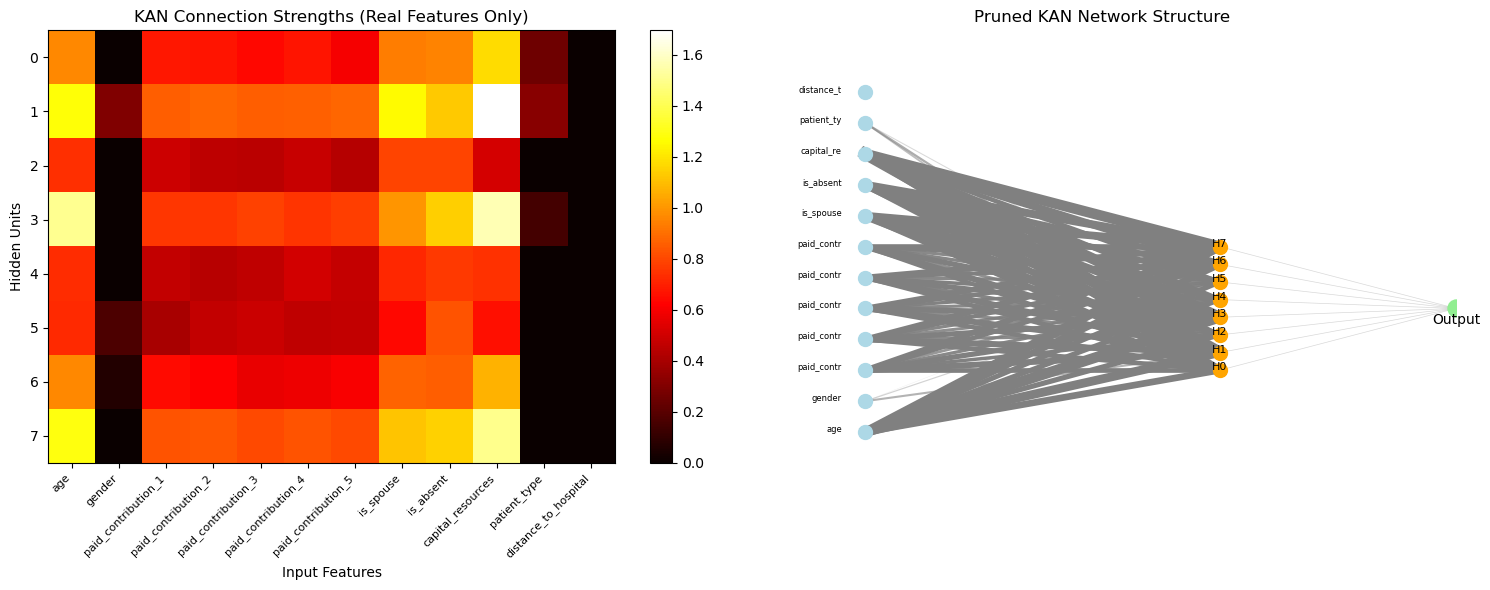


=== HIDDEN UNIT ANALYSIS ===

Hidden Unit 0 responds to:
  age                 : positive response (strength: 0.964)
  paid_contribution_1 : positive response (strength: 0.677)
  paid_contribution_2 : positive response (strength: 0.673)
  paid_contribution_3 : negative response (strength: 0.642)
  paid_contribution_4 : positive response (strength: 0.671)
  paid_contribution_5 : positive response (strength: 0.600)
  is_spouse           : positive response (strength: 0.937)
  is_absent           : positive response (strength: 0.953)
  capital_resources   : positive response (strength: 1.175)
  patient_type        : positive response (strength: 0.254)

Hidden Unit 1 responds to:
  age                 : positive response (strength: 1.273)
  gender              : positive response (strength: 0.298)
  paid_contribution_1 : positive response (strength: 0.860)
  paid_contribution_2 : positive response (strength: 0.878)
  paid_contribution_3 : positive response (strength: 0.859)
  paid_contrib

In [61]:
# Data preparation
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Model initialization 
input_size = X_train_scaled.shape[1]
kan_model = KAN(input_dim=input_size, hidden_dim=8, output_dim=1, grid_size=5)

# Training setup
optimizer = optim.Adam(kan_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch_nn.BCEWithLogitsLoss()

print(f"Model parameters: {sum(p.numel() for p in kan_model.parameters())}")

# Add tracking for sparsity and importance
connection_importance = torch.zeros(input_size, 8)
activation_counts = torch.zeros(input_size, 8)

# Training loop with regularization
kan_model.train()
for epoch in range(100):
    epoch_loss = 0
    num_batches = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = kan_model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        
        l1_reg = torch.sum(torch.abs(kan_model.spline_coeffs))
        
        l1_scales = torch.sum(torch.abs(kan_model.scales))
        
        total_loss = loss + 0.0001 * l1_reg + 0.00005 * l1_scales
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        num_batches += 1
        
        # Track which connections are active
        with torch.no_grad():
            connection_importance += torch.abs(kan_model.scales.detach().cpu())
            activation_counts += (torch.abs(kan_model.scales) > 0.01).float().cpu()
    
    if epoch % 25 == 0:
        avg_loss = epoch_loss / num_batches
        # Report sparsity
        sparsity = (torch.abs(kan_model.scales) < 0.01).float().mean().item()
        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Sparsity = {sparsity:.2%}")

# Prune weak connections after training
print("\n=== PRUNING WEAK CONNECTIONS ===")
with torch.no_grad():
    threshold = 0.05  # Prune connections weaker than this
    mask = torch.abs(kan_model.scales) > threshold
    kan_model.scales.data *= mask.float()
    pruned = (~mask).sum().item()
    total = mask.numel()
    print(f"Pruned {pruned}/{total} connections ({pruned/total:.1%})")

# KAN evaluation
kan_model.eval()
with torch.no_grad():
    kan_outputs = kan_model(X_test_tensor).squeeze()
    kan_probs = torch.sigmoid(kan_outputs)
    kan_pred = (kan_probs > 0.5).float().numpy()

kan_acc = accuracy_score(y_test, kan_pred)
print(f"\nKAN Accuracy after pruning: {kan_acc:.4f}")

# Identify and visualize most important connections
print("\n=== MOST IMPORTANT CONNECTIONS ===")
importance_normalized = connection_importance / (activation_counts + 1e-6)

# Get top connections for each hidden unit
for h in range(8):
    connections = [(feature_cols[i], importance_normalized[i, h].item()) 
                   for i in range(input_size)]
    connections.sort(key=lambda x: x[1], reverse=True)
    
    top_connections = [c for c in connections[:3] if c[1] > 0.1]
    if top_connections:
        print(f"\nHidden Unit {h}:")
        for feat, imp in top_connections:
            feat_type = "REAL" if feat in real_features else "NOISE"
            print(f"  {feat:25s} ({feat_type}): {imp:.3f}")

# Visualize the sparse network structure
def visualize_kan_structure():
    """Visualize the pruned KAN network structure"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Connection strength heatmap
    scales_np = torch.abs(kan_model.scales).detach().cpu().numpy()
    
    # Show only real features for clarity
    real_indices = [i for i, f in enumerate(feature_cols) if f in real_features]
    scales_real = scales_np[real_indices, :]
    
    im1 = ax1.imshow(scales_real.T, cmap='hot', aspect='auto')
    ax1.set_xlabel('Input Features')
    ax1.set_ylabel('Hidden Units')
    ax1.set_title('KAN Connection Strengths (Real Features Only)')
    ax1.set_xticks(range(len(real_features)))
    ax1.set_xticklabels(real_features, rotation=45, ha='right', fontsize=8)
    ax1.set_yticks(range(8))
    plt.colorbar(im1, ax=ax1)
    
    # Plot 2: Network graph showing only strong connections
    ax2.set_title('Pruned KAN Network Structure')
    ax2.set_xlim(-0.5, 2.5)
    ax2.set_ylim(-1, max(len(real_features), 8) + 1)
    ax2.axis('off')
    
    # Draw nodes
    input_y_positions = np.linspace(0, len(real_features)-1, len(real_features))
    hidden_y_positions = np.linspace(2, 6, 8)
    
    # Input nodes
    for i, feat in enumerate(real_features):
        ax2.scatter(0, input_y_positions[i], s=100, c='lightblue', zorder=3)
        ax2.text(-0.1, input_y_positions[i], feat[:10], ha='right', fontsize=6)
    
    # Hidden nodes
    for h in range(8):
        ax2.scatter(1.5, hidden_y_positions[h], s=100, c='orange', zorder=3)
        ax2.text(1.5, hidden_y_positions[h], f'H{h}', ha='center', fontsize=8)
    
    # Output node
    ax2.scatter(2.5, 4, s=150, c='lightgreen', zorder=3)
    ax2.text(2.5, 3.5, 'Output', ha='center')
    
    # Draw edges (only strong connections)
    for i, feat_idx in enumerate(real_indices):
        for h in range(8):
            strength = scales_np[feat_idx, h]
            if strength > 0.05:  # Only show significant connections
                ax2.plot([0, 1.5], [input_y_positions[i], hidden_y_positions[h]], 
                        'gray', alpha=min(strength*2, 1), linewidth=strength*5)
    
    # Hidden to output (simplified)
    for h in range(8):
        ax2.plot([1.5, 2.5], [hidden_y_positions[h], 4], 
                'gray', alpha=0.3, linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig('kan_explainable_structure.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_kan_structure()

# Analyze what each hidden unit learned
def analyze_hidden_units():
    """Analyze what each hidden unit responds to"""
    
    print("\n=== HIDDEN UNIT ANALYSIS ===")
    
    # Create test inputs varying each feature
    baseline = torch.FloatTensor(X_test_scaled.mean(axis=0))
    
    for h in range(8):
        # Skip if hidden unit is mostly pruned
        if (torch.abs(kan_model.scales[:, h]) > 0.05).sum() < 2:
            continue
            
        print(f"\nHidden Unit {h} responds to:")
        
        # Find which features most activate this hidden unit
        activations = []
        for i, feat in enumerate(feature_cols):
            if feat not in real_features:
                continue
                
            # Test feature at extremes
            test_low = baseline.clone()
            test_high = baseline.clone()
            test_low[i] = X_train_scaled[:, i].min()
            test_high[i] = X_train_scaled[:, i].max()
            
            # Get hidden layer activations (before output layer)
            kan_model.eval()
            with torch.no_grad():
                # We need to extract hidden layer activations
                scale_contribution = torch.abs(kan_model.scales[i, h]).item()
                
            if scale_contribution > 0.1:
                direction = "positive" if kan_model.scales[i, h] > 0 else "negative"
                print(f"  {feat:20s}: {direction} response (strength: {scale_contribution:.3f})")

analyze_hidden_units()

# 6. Results Comparison

In [62]:
results = {
    'Logistic Regression': lr_acc,
    'Random Forest': rf_acc,
    'Neural Network': nn_acc,
    'KAN': kan_acc
}

for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Logistic Regression: 0.9939
Random Forest: 0.9981
Neural Network: 0.9973
KAN: 0.9980


# 7. Feature Importance

In [63]:
# RF Features importance
rf_importance = rf.feature_importances_
rf_feature_ranking = list(zip(feature_cols, rf_importance))

# Logistic Regression importance
lr_importance = np.abs(lr.coef_[0])
lr_feature_ranking = list(zip(feature_cols, lr_importance))

# Your KAN importance
def get_kan_importance():
    kan_model.eval()
    baseline_input = torch.FloatTensor(X_test_scaled.mean(axis=0)).unsqueeze(0)
    
    with torch.no_grad():
        baseline_output = kan_model(baseline_input).item()
    
    sensitivities = []
    for i in range(len(feature_cols)):
        feature_values = np.percentile(X_test_scaled[:, i], [10, 50, 90])
        outputs = []
        
        for val in feature_values:
            test_input = baseline_input.clone()
            test_input[0, i] = val
            with torch.no_grad():
                output = kan_model(test_input).item()
            outputs.append(output)
        
        sensitivity = np.max(outputs) - np.min(outputs)
        sensitivities.append(sensitivity)
    
    return np.array(sensitivities)

# KAN importance calculation
kan_importance = get_kan_importance()
kan_feature_ranking = list(zip(feature_cols, kan_importance))

# Display results
print("Enhanced Feature Importance Analysis:")

print("\nLogistic Regression - Top 10:")
lr_sorted = sorted(lr_feature_ranking, key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(lr_sorted[:10], 1):
    feature_type = "REAL" if feature in real_features else "NOISE"
    print(f"{i:2d}. {feature:25s}: {importance:.4f} ({feature_type})")

print(f"\nRandom Forest - Top 10:")
rf_sorted = sorted(rf_feature_ranking, key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(rf_sorted[:10], 1):
    feature_type = "REAL" if feature in real_features else "NOISE"
    print(f"{i:2d}. {feature:25s}: {importance:.4f} ({feature_type})")

print(f"\nKAN - Top 10:")
kan_sorted = sorted(kan_feature_ranking, key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(kan_sorted[:10], 1):
    feature_type = "REAL" if feature in real_features else "NOISE"
    print(f"{i:2d}. {feature:25s}: {importance:.4f} ({feature_type})")

Enhanced Feature Importance Analysis:

Logistic Regression - Top 10:
 1. is_absent                : 3.3369 (REAL)
 2. is_spouse                : 3.3199 (REAL)
 3. capital_resources        : 3.1139 (REAL)
 4. age                      : 2.4009 (REAL)
 5. paid_contribution_2      : 1.6521 (REAL)
 6. paid_contribution_4      : 1.6455 (REAL)
 7. paid_contribution_1      : 1.6233 (REAL)
 8. paid_contribution_5      : 1.5841 (REAL)
 9. paid_contribution_3      : 1.5672 (REAL)
10. gender                   : 0.1622 (REAL)

Random Forest - Top 10:
 1. capital_resources        : 0.2503 (REAL)
 2. age                      : 0.2146 (REAL)
 3. is_absent                : 0.1413 (REAL)
 4. is_spouse                : 0.1399 (REAL)
 5. paid_contribution_2      : 0.0542 (REAL)
 6. paid_contribution_1      : 0.0541 (REAL)
 7. paid_contribution_5      : 0.0534 (REAL)
 8. paid_contribution_3      : 0.0402 (REAL)
 9. paid_contribution_4      : 0.0390 (REAL)
10. patient_type             : 0.0006 (REAL)

KAN -

# 8. Classification Reports

In [36]:
print("Logistic Regression:")
print(classification_report(y_test, lr_pred, target_names=['Not Eligible', 'Eligible']))

print("Random Forest:")
print(classification_report(y_test, rf_pred, target_names=['Not Eligible', 'Eligible']))

print("Neural Network:")
print(classification_report(y_test, nn_pred, target_names=['Not Eligible', 'Eligible']))

print("KAN:")
print(classification_report(y_test, kan_pred, target_names=['Not Eligible', 'Eligible']))

Logistic Regression:
              precision    recall  f1-score   support

Not Eligible       1.00      0.99      0.99      5000
    Eligible       0.99      1.00      0.99      5000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Random Forest:
              precision    recall  f1-score   support

Not Eligible       1.00      1.00      1.00      5000
    Eligible       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Neural Network:
              precision    recall  f1-score   support

Not Eligible       1.00      0.99      1.00      5000
    Eligible       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.0

# 9. Rule Based Testing

In [71]:
def create_comprehensive_rule_tests_expanded():
    """Create comprehensive test cases with MORE edge cases for better model discrimination"""
    
    test_cases = []
    
    # Base case that satisfies ALL rules
    base_case = {
        'age': 67,
        'gender': 1,  # Male
        'is_spouse': 1,
        'is_absent': 0,
        'capital_resources': 2000,
        'patient_type': 1,  # In-patient
        'distance_to_hospital': 30,
        'paid_contribution_1': 1,
        'paid_contribution_2': 1,
        'paid_contribution_3': 1,
        'paid_contribution_4': 1,
        'paid_contribution_5': 1
    }
    
    # Add noise features to base case
    for i in range(1, 53):
        base_case[f'noise_{i}'] = X_train[f'noise_{i}'].mean()
    
    # EXPANDED: Test Rule 1 - Age-Gender thresholds (was 6, now 20 cases)
    # Male age tests - finer granularity around threshold
    for age in [62, 63, 64, 64.5, 64.9, 65, 65.1, 65.5, 66, 68, 70]:
        expected = age >= 65
        test_cases.append(
            (f'male_age_{age}', {**base_case, 'age': age, 'gender': 1}, expected)
        )
    
    # Female age tests - finer granularity around threshold
    for age in [57, 58, 59, 59.5, 59.9, 60, 60.1, 60.5, 61, 63, 65]:
        expected = age >= 60
        test_cases.append(
            (f'female_age_{age}', {**base_case, 'age': age, 'gender': 0}, expected)
        )
    
    # EXPANDED: Test Rule 2 - Contribution requirements (was 4, now 15 cases)
    contribution_patterns = [
        ([1,1,1,1,1], True, '5of5'),  # All contributions
        ([1,1,1,1,0], True, '4of5_last'),  # Missing last
        ([0,1,1,1,1], True, '4of5_first'),  # Missing first
        ([1,0,1,1,1], True, '4of5_second'),  # Missing second
        ([1,1,0,1,1], True, '4of5_middle'),  # Missing middle
        ([1,1,1,0,0], False, '3of5_last2'),  # Missing last two
        ([0,0,1,1,1], False, '3of5_first2'),  # Missing first two
        ([1,0,0,1,1], False, '3of5_mid2'),  # Missing middle two
        ([1,0,1,0,1], False, '3of5_alternate'),  # Alternating pattern
        ([1,1,0,0,0], False, '2of5_first2'),  # Only first two
        ([0,0,0,1,1], False, '2of5_last2'),  # Only last two
        ([1,0,0,0,1], False, '2of5_ends'),  # Only ends
        ([0,1,0,1,0], False, '2of5_alternate'),  # Alternating
        ([1,0,0,0,0], False, '1of5'),  # Only one
        ([0,0,0,0,0], False, '0of5'),  # None
    ]
    
    for contrib_list, expected, pattern_name in contribution_patterns:
        test_case = base_case.copy()
        for i, val in enumerate(contrib_list, 1):
            test_case[f'paid_contribution_{i}'] = val
        test_cases.append((f'contrib_{pattern_name}', test_case, expected))
    
    # EXPANDED: Test Rule 3 - Spouse requirement (simple, but add context variations)
    spouse_contexts = [
        (1, 67, 1, True, 'spouse_eligible_base'),
        (0, 67, 1, False, 'not_spouse_otherwise_ok'),
        (1, 55, 1, False, 'spouse_but_young'),  # Spouse but fails age
        (0, 55, 1, False, 'not_spouse_and_young'),  # Fails both
    ]
    
    for spouse, age, gender, expected, context in spouse_contexts:
        test_cases.append(
            (f'spouse_{context}', {**base_case, 'is_spouse': spouse, 'age': age, 'gender': gender}, expected)
        )
    
    # EXPANDED: Test Rule 4 - Absence requirement (with context)
    absence_contexts = [
        (0, 67, 1, True, 'not_absent_eligible'),
        (1, 67, 1, False, 'absent_otherwise_ok'),
        (0, 55, 1, False, 'not_absent_but_young'),
        (1, 55, 1, False, 'absent_and_young'),
    ]
    
    for absent, age, gender, expected, context in absence_contexts:
        test_cases.append(
            (f'absent_{context}', {**base_case, 'is_absent': absent, 'age': age, 'gender': gender}, expected)
        )
    
    # EXPANDED: Test Rule 5 - Capital resources limit (was 4, now 12 cases)
    capital_thresholds = [
        (0, True, 'zero'),
        (500, True, 'low'),
        (1500, True, 'mid_low'),
        (2500, True, 'mid_high'),
        (2900, True, 'near_threshold'),
        (2999, True, 'just_under'),
        (3000, True, 'exactly_threshold'),
        (3001, False, 'just_over'),
        (3100, False, 'slightly_over'),
        (3500, False, 'mid_over'),
        (5000, False, 'high_over'),
        (10000, False, 'very_high'),
    ]
    
    for capital, expected, context in capital_thresholds:
        test_cases.append(
            (f'capital_{context}', {**base_case, 'capital_resources': capital}, expected)
        )
    
    # EXPANDED: Test Rule 6 - Patient type and distance (was 6, now 16 cases)
    # In-patient cases (must be within 50km)
    inpatient_distances = [
        (0, True, 'zero_km'),
        (10, True, 'very_close'),
        (25, True, 'close'),
        (40, True, 'moderate'),
        (49, True, 'near_threshold'),
        (50, True, 'exactly_threshold'),
        (51, False, 'just_over'),
        (60, False, 'over'),
        (100, False, 'far'),
    ]
    
    for distance, expected, context in inpatient_distances:
        test_cases.append(
            (f'inpatient_{context}', {**base_case, 'patient_type': 1, 'distance_to_hospital': distance}, expected)
        )
    
    # Out-patient cases (must be beyond 50km)
    outpatient_distances = [
        (100, True, 'far'),
        (75, True, 'moderate_far'),
        (60, True, 'slightly_far'),
        (51, True, 'just_over_threshold'),
        (50, False, 'exactly_threshold'),
        (49, False, 'just_under'),
        (40, False, 'moderate_close'),
        (25, False, 'close'),
        (10, False, 'very_close'),
        (0, False, 'zero_km'),
    ]
    
    for distance, expected, context in outpatient_distances:
        test_cases.append(
            (f'outpatient_{context}', {**base_case, 'patient_type': 0, 'distance_to_hospital': distance}, expected)
        )
    
    # EXPANDED: Complex combinations testing multiple rule interactions
    complex_cases = [
        # Age boundary combinations with other rules
        ('male_64_spouse_ok', {**base_case, 'age': 64, 'gender': 1}, False),  # Just fails age
        ('male_65_not_spouse', {**base_case, 'age': 65, 'gender': 1, 'is_spouse': 0}, False),  # Passes age, fails spouse
        ('female_59_4contrib', {**base_case, 'age': 59, 'gender': 0, 'paid_contribution_5': 0}, False),  # Fails age
        ('female_60_3contrib', {**base_case, 'age': 60, 'gender': 0, 'paid_contribution_4': 0, 'paid_contribution_5': 0}, False),  # Passes age, fails contrib
        
        # Capital boundary with other rules
        ('capital_3000_all_ok', {**base_case, 'capital_resources': 3000}, True),  # Exactly at threshold
        ('capital_3001_all_ok', {**base_case, 'capital_resources': 3001}, False),  # Just over threshold
        ('capital_2999_not_spouse', {**base_case, 'capital_resources': 2999, 'is_spouse': 0}, False),  # Under capital but fails spouse
        
        # Distance boundary combinations
        ('inpatient_50_all_ok', {**base_case, 'patient_type': 1, 'distance_to_hospital': 50}, True),
        ('inpatient_51_otherwise_ok', {**base_case, 'patient_type': 1, 'distance_to_hospital': 51}, False),
        ('outpatient_50_all_ok', {**base_case, 'patient_type': 0, 'distance_to_hospital': 50}, False),
        ('outpatient_51_all_ok', {**base_case, 'patient_type': 0, 'distance_to_hospital': 51}, True),
        
        # Triple failures
        ('triple_fail_age_spouse_capital', {**base_case, 'age': 64, 'is_spouse': 0, 'capital_resources': 3001}, False),
        ('triple_fail_age_absent_distance', {**base_case, 'age': 64, 'is_absent': 1, 'distance_to_hospital': 51}, False),
        
        # All boundaries
        ('all_boundaries_male', {**base_case, 'age': 65, 'gender': 1, 'capital_resources': 3000, 'distance_to_hospital': 50, 'paid_contribution_5': 0}, True),
        ('all_boundaries_female', {**base_case, 'age': 60, 'gender': 0, 'capital_resources': 3000, 'distance_to_hospital': 50, 'paid_contribution_5': 0}, True),
    ]
    
    test_cases.extend(complex_cases)
    
    return test_cases

# Modified evaluation function to handle expanded test cases
def evaluate_models_on_rules_expanded(test_cases):
    """Evaluate all models on expanded rule-based test cases"""
    
    results = {
        'LR': {'correct': 0, 'total': 0, 'by_rule': {}},
        'RF': {'correct': 0, 'total': 0, 'by_rule': {}},
        'NN': {'correct': 0, 'total': 0, 'by_rule': {}},
        'KAN': {'correct': 0, 'total': 0, 'by_rule': {}}
    }
    
    detailed_results = []
    
    for test_name, test_data, expected in test_cases:
        # Prepare test data
        test_df = pd.DataFrame([test_data])
        test_X = test_df[feature_cols]
        test_X_scaled = scaler.transform(test_X)
        
        # Get predictions
        lr_prob = lr.predict_proba(test_X_scaled)[0, 1]
        rf_prob = rf.predict_proba(test_X)[0, 1]
        nn_prob = nn.predict_proba(test_X_scaled)[0, 1]
        
        kan_model.eval()
        with torch.no_grad():
            kan_logit = kan_model(torch.FloatTensor(test_X_scaled)).item()
            kan_prob = torch.sigmoid(torch.tensor(kan_logit)).item()
        
        # Check predictions
        lr_pred = lr_prob > 0.5
        rf_pred = rf_prob > 0.5
        nn_pred = nn_prob > 0.5
        kan_pred = kan_prob > 0.5
        
        # Store detailed results
        detailed_results.append({
            'test': test_name,
            'expected': expected,
            'LR_prob': lr_prob,
            'RF_prob': rf_prob,
            'NN_prob': nn_prob,
            'KAN_prob': kan_prob,
            'LR_correct': lr_pred == expected,
            'RF_correct': rf_pred == expected,
            'NN_correct': nn_pred == expected,
            'KAN_correct': kan_pred == expected
        })
        
        # Update summary stats
        for model in ['LR', 'RF', 'NN', 'KAN']:
            model_correct = detailed_results[-1][f'{model}_correct']
            results[model]['correct'] += model_correct
            results[model]['total'] += 1
            
            # Track by rule category (extract from test name)
            if 'male_age' in test_name:
                rule_category = 'male_age'
            elif 'female_age' in test_name:
                rule_category = 'female_age'
            elif 'contrib' in test_name:
                rule_category = 'contrib'
            elif 'spouse' in test_name:
                rule_category = 'spouse'
            elif 'absent' in test_name:
                rule_category = 'absent'
            elif 'capital' in test_name:
                rule_category = 'capital'
            elif 'inpatient' in test_name:
                rule_category = 'inpatient'
            elif 'outpatient' in test_name:
                rule_category = 'outpatient'
            elif 'complex' in test_name or 'triple' in test_name or 'all_boundaries' in test_name:
                rule_category = 'complex'
            else:
                rule_category = 'other'
            
            if rule_category not in results[model]['by_rule']:
                results[model]['by_rule'][rule_category] = {'correct': 0, 'total': 0}
            results[model]['by_rule'][rule_category]['correct'] += model_correct
            results[model]['by_rule'][rule_category]['total'] += 1
    
    return results, detailed_results

# Run expanded testing
print("=" * 80)
print("EXPANDED COMPREHENSIVE RULE TESTING")
print("=" * 80)

# Create expanded test cases
test_cases_expanded = create_comprehensive_rule_tests_expanded()
print(f"\nCreated {len(test_cases_expanded)} test cases (expanded from 27)")
print("\nBreakdown of test cases:")
print(f"  Age tests (male): {sum(1 for t in test_cases_expanded if 'male_age' in t[0])}")
print(f"  Age tests (female): {sum(1 for t in test_cases_expanded if 'female_age' in t[0])}")
print(f"  Contribution patterns: {sum(1 for t in test_cases_expanded if 'contrib_' in t[0])}")
print(f"  Capital thresholds: {sum(1 for t in test_cases_expanded if 'capital_' in t[0])}")
print(f"  Distance tests: {sum(1 for t in test_cases_expanded if 'patient_' in t[0])}")
print(f"  Complex combinations: {sum(1 for t in test_cases_expanded if any(x in t[0] for x in ['complex', 'triple', 'all_boundaries']))}")

# Evaluate models
results_expanded, detailed_results_expanded = evaluate_models_on_rules_expanded(test_cases_expanded)

# Print detailed results
print("\n" + "=" * 80)
print("EXPANDED TEST RESULTS")
print("=" * 80)

print("\nOverall Accuracy on Expanded Rule Tests:")
for model in ['LR', 'RF', 'NN', 'KAN']:
    acc = results_expanded[model]['correct'] / results_expanded[model]['total']
    print(f"  {model:5s}: {results_expanded[model]['correct']}/{results_expanded[model]['total']} = {acc:.1%}")

print("\nDetailed Accuracy by Rule Type:")
print("  " + "-" * 70)
print(f"  {'Rule Category':15s} | {'Tests':>6s} | {'LR':>7s} | {'RF':>7s} | {'NN':>7s} | {'KAN':>7s}")
print("  " + "-" * 70)

rule_categories_expanded = [
    ('Age (Male)', 'male_age'),
    ('Age (Female)', 'female_age'),
    ('Contributions', 'contrib'),
    ('Spouse', 'spouse'),
    ('Absence', 'absent'),
    ('Capital', 'capital'),
    ('In-patient', 'inpatient'),
    ('Out-patient', 'outpatient'),
    ('Complex', 'complex'),
]

for display_name, category in rule_categories_expanded:
    row = f"  {display_name:15s} |"
    
    # Get number of tests for this category
    n_tests = results_expanded['LR']['by_rule'].get(category, {}).get('total', 0)
    row += f" {n_tests:6d} |"
    
    for model in ['LR', 'RF', 'NN', 'KAN']:
        if category in results_expanded[model]['by_rule']:
            correct = results_expanded[model]['by_rule'][category]['correct']
            total = results_expanded[model]['by_rule'][category]['total']
            acc = correct / total
            row += f" {acc:6.1%} |"
        else:
            row += "    N/A |"
    print(row)

# Find where models diverge most
print("\n" + "=" * 80)
print("KEY DIFFERENTIATORS (Cases where models disagree)")
print("=" * 80)

disagreements = []
for result in detailed_results_expanded:
    predictions = [result['LR_correct'], result['RF_correct'], 
                  result['NN_correct'], result['KAN_correct']]
    if len(set(predictions)) > 1:  # Models disagree
        disagreements.append(result)

print(f"\nFound {len(disagreements)} test cases where models disagree")
print("\nTop 10 disagreement cases:")
for i, case in enumerate(disagreements[:10], 1):
    print(f"\n{i}. {case['test']} (Expected: {'ELIGIBLE' if case['expected'] else 'INELIGIBLE'})")
    print(f"   LR: {'✓' if case['LR_correct'] else '✗'} ({case['LR_prob']:.3f})")
    print(f"   RF: {'✓' if case['RF_correct'] else '✗'} ({case['RF_prob']:.3f})") 
    print(f"   NN: {'✓' if case['NN_correct'] else '✗'} ({case['NN_prob']:.3f})")
    print(f"   KAN: {'✓' if case['KAN_correct'] else '✗'} ({case['KAN_prob']:.3f})")

print("\n" + "=" * 80)
print("INSIGHTS FROM EXPANDED TESTING")
print("=" * 80)
print("""
With more edge cases, we can now see:
1. Which models handle boundary conditions better
2. Where each model's decision boundary actually lies
3. Which rules are consistently difficult for all models
4. Whether KAN's splines provide any advantage at thresholds
""")

EXPANDED COMPREHENSIVE RULE TESTING

Created 91 test cases (expanded from 27)

Breakdown of test cases:
  Age tests (male): 22
  Age tests (female): 11
  Contribution patterns: 15
  Capital thresholds: 15
  Distance tests: 23
  Complex combinations: 4

EXPANDED TEST RESULTS

Overall Accuracy on Expanded Rule Tests:
  LR   : 61/91 = 67.0%
  RF   : 66/91 = 72.5%
  NN   : 61/91 = 67.0%
  KAN  : 61/91 = 67.0%

Detailed Accuracy by Rule Type:
  ----------------------------------------------------------------------
  Rule Category   |  Tests |      LR |      RF |      NN |     KAN
  ----------------------------------------------------------------------
  Age (Male)      |     22 |  54.5% |  72.7% |  54.5% |  54.5% |
  Age (Female)    |      0 |    N/A |    N/A |    N/A |    N/A |
  Contributions   |     17 |  94.1% |  70.6% |  94.1% |  94.1% |
  Spouse          |      8 |  75.0% |  87.5% |  75.0% |  75.0% |
  Absence         |      5 |  80.0% | 100.0% |  80.0% |  80.0% |
  Capital         | 

# 10. Visualization

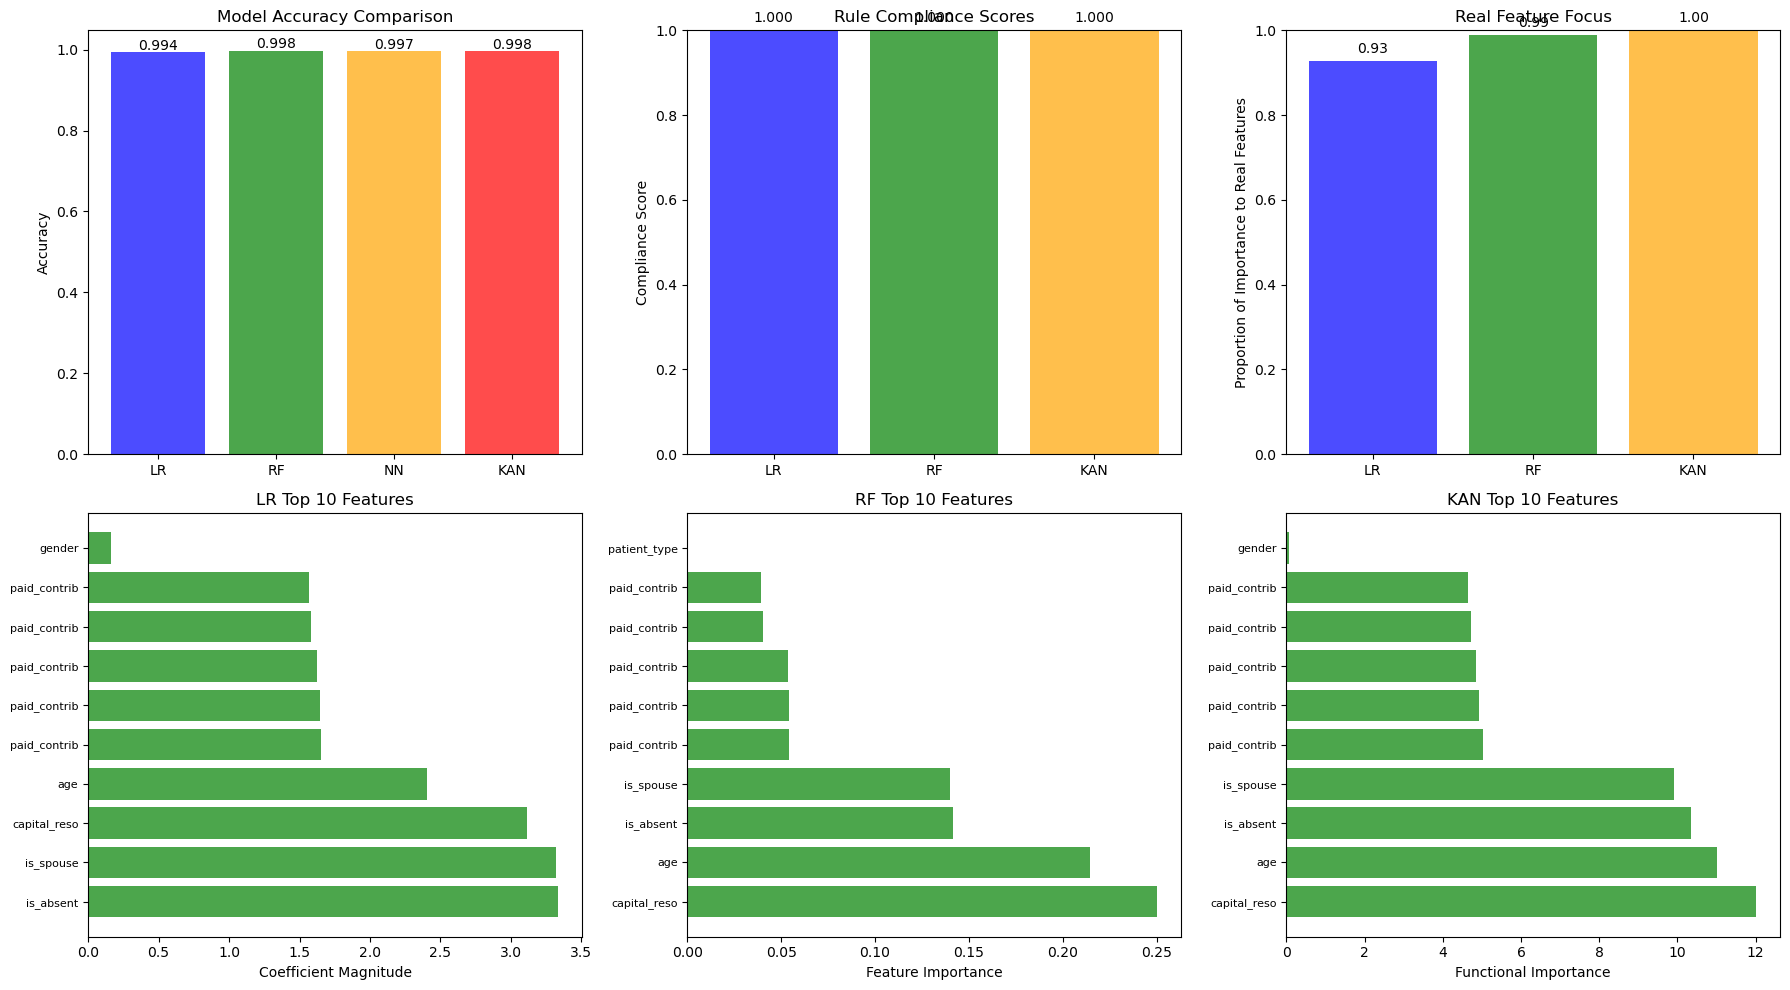

In [65]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy comparison
models = ['LR', 'RF', 'NN', 'KAN']
accuracies = [lr_acc, rf_acc, nn_acc, kan_acc]
colors = ['blue', 'green', 'orange', 'red']

axes[0, 0].bar(models, accuracies, color=colors, alpha=0.7)
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
for i, acc in enumerate(accuracies):
    axes[0, 0].text(i, acc + 0.005, f'{acc:.3f}', ha='center')

# Rule compliance analysis
lr_coeff = lr.coef_[0]
lr_rules = {
    'age_positive': lr_coeff[feature_cols.index('age')] > 0,
    'spouse_positive': lr_coeff[feature_cols.index('is_spouse')] > 0,
    'absent_negative': lr_coeff[feature_cols.index('is_absent')] < 0,
    'capital_negative': lr_coeff[feature_cols.index('capital_resources')] < 0
}
lr_compliance = np.mean(list(lr_rules.values()))

rf_top_10 = [f[0] for f in rf_feature_ranking[:10]]
rf_real_count = sum(1 for f in rf_top_10 if f in real_features)
rf_compliance = rf_real_count / 10.0

kan_top_10 = [f[0] for f in kan_feature_ranking[:10]]
kan_real_count = sum(1 for f in kan_top_10 if f in real_features)
kan_compliance = kan_real_count / 10.0

rule_scores = [lr_compliance, rf_compliance, kan_compliance]
axes[0, 1].bar(['LR', 'RF', 'KAN'], rule_scores, color=colors[:3], alpha=0.7)
axes[0, 1].set_title('Rule Compliance Scores')
axes[0, 1].set_ylabel('Compliance Score')
axes[0, 1].set_ylim(0, 1)
for i, score in enumerate(rule_scores):
    axes[0, 1].text(i, score + 0.02, f'{score:.3f}', ha='center')

# Real vs noise feature analysis
real_indices = [i for i, f in enumerate(feature_cols) if f in real_features]
noise_indices = [i for i, f in enumerate(feature_cols) if f in noise_features]

# LR feature focus
lr_importance = np.abs(lr.coef_[0])
lr_real_sum = np.sum(lr_importance[real_indices])
lr_total_sum = np.sum(lr_importance)
lr_focus = lr_real_sum / lr_total_sum

# RF feature focus
rf_real_sum = np.sum(rf.feature_importances_[real_indices])
rf_total_sum = np.sum(rf.feature_importances_)
rf_focus = rf_real_sum / rf_total_sum

# KAN feature focus
kan_real_sum = np.sum(kan_importance[real_indices])
kan_total_sum = np.sum(kan_importance)
kan_focus = kan_real_sum / kan_total_sum

focus_scores = [lr_focus, rf_focus, kan_focus]
axes[0, 2].bar(['LR', 'RF', 'KAN'], focus_scores, color=colors[:3], alpha=0.7)
axes[0, 2].set_title('Real Feature Focus')
axes[0, 2].set_ylabel('Proportion of Importance to Real Features')
axes[0, 2].set_ylim(0, 1)
for i, score in enumerate(focus_scores):
    axes[0, 2].text(i, score + 0.02, f'{score:.2f}', ha='center')

# LR feature importance with color coding
lr_sorted = sorted(zip(feature_cols, lr_importance), key=lambda x: x[1], reverse=True)
top_10_lr = lr_sorted[:10]
features_lr = [f[0][:12] for f in top_10_lr]
importance_lr = [f[1] for f in top_10_lr]
colors_lr = ['green' if f[0] in real_features else 'red' for f in top_10_lr]

axes[1, 0].barh(range(len(features_lr)), importance_lr, color=colors_lr, alpha=0.7)
axes[1, 0].set_yticks(range(len(features_lr)))
axes[1, 0].set_yticklabels(features_lr, fontsize=8)
axes[1, 0].set_title('LR Top 10 Features')
axes[1, 0].set_xlabel('Coefficient Magnitude')

# RF feature importance with color coding
rf_sorted = sorted(rf_feature_ranking, key=lambda x: x[1], reverse=True)
top_10_rf = rf_sorted[:10]
features_rf = [f[0][:12] for f in top_10_rf]
importance_rf = [f[1] for f in top_10_rf]
colors_rf = ['green' if f[0] in real_features else 'red' for f in top_10_rf]

axes[1, 1].barh(range(len(features_rf)), importance_rf, color=colors_rf, alpha=0.7)
axes[1, 1].set_yticks(range(len(features_rf)))
axes[1, 1].set_yticklabels(features_rf, fontsize=8)
axes[1, 1].set_title('RF Top 10 Features')
axes[1, 1].set_xlabel('Feature Importance')

# KAN feature importance with color coding
kan_sorted = sorted(kan_feature_ranking, key=lambda x: x[1], reverse=True)
top_10_kan = kan_sorted[:10]
features_kan = [f[0][:12] for f in top_10_kan]
importance_kan = [f[1] for f in top_10_kan]
colors_kan = ['green' if f[0] in real_features else 'red' for f in top_10_kan]

axes[1, 2].barh(range(len(features_kan)), importance_kan, color=colors_kan, alpha=0.7)
axes[1, 2].set_yticks(range(len(features_kan)))
axes[1, 2].set_yticklabels(features_kan, fontsize=8)
axes[1, 2].set_title('KAN Top 10 Features')
axes[1, 2].set_xlabel('Functional Importance')

plt.tight_layout()
plt.show()



# 11. Counterfactuals Test

In [66]:


def test_counterfactual_explanations():
    """Test models' ability to generate meaningful counterfactual explanations"""
    
    print("Testing Counterfactual Explanation Generation...")
    
    # Start with an ineligible case
    base_ineligible = {
        'age': 55, 'gender': 1, 'is_spouse': 0, 'is_absent': 1,  # Multiple violations
        'capital_resources': 4000, 'patient_type': 1, 'distance_to_hospital': 30,
        'paid_contribution_1': 1, 'paid_contribution_2': 0,  # Only 2/5 contributions
        'paid_contribution_3': 0, 'paid_contribution_4': 1, 'paid_contribution_5': 0
    }
    
    # Add noise features
    for i in range(1, 53):
        base_ineligible[f'noise_{i}'] = X_train[f'noise_{i}'].mean()
    
    # Test minimal changes needed to become eligible
    counterfactual_tests = [
        ('fix_age_only', {**base_ineligible, 'age': 70}, 'Change only age to 70'),
        ('fix_spouse_only', {**base_ineligible, 'is_spouse': 1}, 'Change only spouse status'),
        ('fix_absence_only', {**base_ineligible, 'is_absent': 0}, 'Change only absence status'),
        ('fix_capital_only', {**base_ineligible, 'capital_resources': 2000}, 'Change only capital'),
        ('fix_contributions_only', {**base_ineligible, 'paid_contribution_2': 1, 'paid_contribution_3': 1}, 'Fix contributions (4/5)'),
        ('fix_multiple', {**base_ineligible, 'age': 70, 'is_spouse': 1, 'is_absent': 0}, 'Fix age + spouse + absence'),
    ]
    
    # Get baseline prediction
    base_df = pd.DataFrame([base_ineligible])
    base_X_scaled = scaler.transform(base_df[feature_cols])
    
    print(f"\nBaseline (ineligible) case predictions:")
    lr_base = lr.predict_proba(base_X_scaled)[0][1]
    rf_base = rf.predict_proba(base_df[feature_cols])[0][1]
    nn_base = nn.predict_proba(base_X_scaled)[0][1]
    
    kan_model.eval()
    with torch.no_grad():
        kan_base = torch.sigmoid(kan_model(torch.FloatTensor(base_X_scaled))).item()
    
    print(f"  LR: {lr_base:.3f} | RF: {rf_base:.3f} | NN: {nn_base:.3f} | KAN: {kan_base:.3f}")
    
    counterfactual_results = {}
    
    for test_name, test_case, description in counterfactual_tests:
        test_df = pd.DataFrame([test_case])
        test_X_scaled = scaler.transform(test_df[feature_cols])
        
        # Get predictions
        lr_prob = lr.predict_proba(test_X_scaled)[0][1]
        rf_prob = rf.predict_proba(test_df[feature_cols])[0][1]
        nn_prob = nn.predict_proba(test_X_scaled)[0][1]
        
        kan_model.eval()
        with torch.no_grad():
            kan_prob = torch.sigmoid(kan_model(torch.FloatTensor(test_X_scaled))).item()
        
        # Calculate improvement from baseline
        lr_improvement = lr_prob - lr_base
        rf_improvement = rf_prob - rf_base
        nn_improvement = nn_prob - nn_base
        kan_improvement = kan_prob - kan_base
        
        counterfactual_results[test_name] = {
            'description': description,
            'LR_prob': lr_prob,
            'RF_prob': rf_prob,
            'NN_prob': nn_prob,
            'KAN_prob': kan_prob,
            'LR_improvement': lr_improvement,
            'RF_improvement': rf_improvement,
            'NN_improvement': nn_improvement,
            'KAN_improvement': kan_improvement
        }
        
        print(f"\n{test_name}: {description}")
        print(f"  Probabilities: LR: {lr_prob:.3f} | RF: {rf_prob:.3f} | NN: {nn_prob:.3f} | KAN: {kan_prob:.3f}")
        print(f"  Improvements:  LR: {lr_improvement:+.3f} | RF: {rf_improvement:+.3f} | NN: {nn_improvement:+.3f} | KAN: {kan_improvement:+.3f}")
    
    return counterfactual_results

def test_feature_perturbation_sensitivity():
    """Test how models respond to systematic feature perturbations"""
    
    print("\nTesting Feature Perturbation Sensitivity...")
    
    # Start with borderline eligible case
    borderline_case = {
        'age': 65, 'gender': 1, 'is_spouse': 1, 'is_absent': 0,
        'capital_resources': 2800, 'patient_type': 1, 'distance_to_hospital': 30,  # Close to 3000 limit
        'paid_contribution_1': 1, 'paid_contribution_2': 1,
        'paid_contribution_3': 1, 'paid_contribution_4': 1, 'paid_contribution_5': 0  # Exactly 4/5
    }
    
    # Add noise features
    for i in range(1, 53):
        borderline_case[f'noise_{i}'] = X_train[f'noise_{i}'].mean()
    
    # Test perturbations around decision boundaries
    perturbation_tests = [
        ('capital_increase', 'capital_resources', [2500, 2800, 3000, 3200, 3500], 'Capital near threshold'),
        ('age_decrease', 'age', [67, 65, 63, 61, 59], 'Age around threshold'),
        ('remove_contribution', 'paid_contribution_4', [1, 0], 'Remove one contribution'),
        ('noise_perturbation', 'noise_1', [-2, -1, 0, 1, 2], 'Noise feature variation')
    ]
    
    perturbation_results = {}
    
    for test_name, feature, values, description in perturbation_tests:
        print(f"\n{test_name}: {description}")
        print(f"  {feature} values: {values}")
        
        model_responses = {'LR': [], 'RF': [], 'NN': [], 'KAN': []}
        
        for value in values:
            test_case = borderline_case.copy()
            test_case[feature] = value
            
            test_df = pd.DataFrame([test_case])
            test_X_scaled = scaler.transform(test_df[feature_cols])
            
            # Get predictions
            lr_prob = lr.predict_proba(test_X_scaled)[0][1]
            rf_prob = rf.predict_proba(test_df[feature_cols])[0][1]
            nn_prob = nn.predict_proba(test_X_scaled)[0][1]
            
            kan_model.eval()
            with torch.no_grad():
                kan_prob = torch.sigmoid(kan_model(torch.FloatTensor(test_X_scaled))).item()
            
            model_responses['LR'].append(lr_prob)
            model_responses['RF'].append(rf_prob)
            model_responses['NN'].append(nn_prob)
            model_responses['KAN'].append(kan_prob)
        
        # Calculate sensitivity (range of responses)
        sensitivities = {}
        for model, responses in model_responses.items():
            sensitivity = max(responses) - min(responses)
            sensitivities[model] = sensitivity
            print(f"  {model} responses: {[f'{r:.3f}' for r in responses]} (range: {sensitivity:.3f})")
        
        perturbation_results[test_name] = {
            'description': description,
            'feature': feature,
            'values': values,
            'responses': model_responses,
            'sensitivities': sensitivities
        }
    
    return perturbation_results

def test_monotonicity_constraints():
    """Test if models respect expected monotonicity in features"""
    
    print("\nTesting Monotonicity Constraints...")
    
    baseline_case = {
        'age': 65, 'gender': 1, 'is_spouse': 1, 'is_absent': 0,
        'capital_resources': 2500, 'patient_type': 1, 'distance_to_hospital': 30,
        'paid_contribution_1': 1, 'paid_contribution_2': 1,
        'paid_contribution_3': 1, 'paid_contribution_4': 1, 'paid_contribution_5': 0
    }
    
    # Add noise features
    for i in range(1, 53):
        baseline_case[f'noise_{i}'] = X_train[f'noise_{i}'].mean()
    
    monotonicity_tests = [
        ('age_increasing', 'age', [60, 62, 64, 66, 68, 70], 'positive', 'Age should increase eligibility'),
        ('capital_decreasing', 'capital_resources', [4000, 3500, 3000, 2500, 2000, 1500], 'negative', 'Higher capital should decrease eligibility'),
    ]
    
    monotonicity_results = {}
    
    for test_name, feature, values, expected_direction, description in monotonicity_tests:
        print(f"\n{test_name}: {description}")
        
        model_responses = {'LR': [], 'RF': [], 'NN': [], 'KAN': []}
        
        for value in values:
            test_case = baseline_case.copy()
            test_case[feature] = value
            
            test_df = pd.DataFrame([test_case])
            test_X_scaled = scaler.transform(test_df[feature_cols])
            
            lr_prob = lr.predict_proba(test_X_scaled)[0][1]
            rf_prob = rf.predict_proba(test_df[feature_cols])[0][1]
            nn_prob = nn.predict_proba(test_X_scaled)[0][1]
            
            kan_model.eval()
            with torch.no_grad():
                kan_prob = torch.sigmoid(kan_model(torch.FloatTensor(test_X_scaled))).item()
            
            model_responses['LR'].append(lr_prob)
            model_responses['RF'].append(rf_prob)
            model_responses['NN'].append(nn_prob)
            model_responses['KAN'].append(kan_prob)
        
        # Check monotonicity
        monotonicity_scores = {}
        for model, responses in model_responses.items():
            violations = 0
            for i in range(len(responses) - 1):
                if expected_direction == 'positive' and responses[i+1] < responses[i]:
                    violations += 1
                elif expected_direction == 'negative' and responses[i+1] > responses[i]:
                    violations += 1
            
            monotonicity_score = 1 - (violations / (len(responses) - 1))
            monotonicity_scores[model] = monotonicity_score
            
            print(f"  {model}: {[f'{r:.3f}' for r in responses]} (monotonicity: {monotonicity_score:.2f})")
        
        monotonicity_results[test_name] = {
            'description': description,
            'feature': feature,
            'expected_direction': expected_direction,
            'responses': model_responses,
            'monotonicity_scores': monotonicity_scores
        }
    
    return monotonicity_results

def comprehensive_counterfactual_evaluation():
    """Run complete counterfactual analysis"""
    
    print("="*60)
    print("COUNTERFACTUAL EXPLANATION ANALYSIS")
    print("="*60)
    
    # Test 1: Counterfactual generation
    counterfactual_results = test_counterfactual_explanations()
    
    # Test 2: Feature perturbation sensitivity
    perturbation_results = test_feature_perturbation_sensitivity()
    
    # Test 3: Monotonicity constraints
    monotonicity_results = test_monotonicity_constraints()
    
    print("\n" + "="*60)
    print("COUNTERFACTUAL ANALYSIS SUMMARY")
    print("="*60)
    
    print("\n1. COUNTERFACTUAL EFFECTIVENESS:")
    print("   [Which single changes most effectively flip predictions?]")
    
    print("\n2. FEATURE PERTURBATION SENSITIVITY:")
    print("   [How sensitive are models to changes around decision boundaries?]")
    
    print("\n3. MONOTONICITY COMPLIANCE:")
    print("   [Do models respect expected feature-outcome relationships?]")
    
    return {
        'counterfactuals': counterfactual_results,
        'perturbations': perturbation_results,
        'monotonicity': monotonicity_results
    }

# Add this to your main evaluation
def extended_model_evaluation():
    """Complete evaluation including counterfactuals"""
    
    # Run existing comprehensive evaluation
     #standard_results = comprehensive_model_evaluation()
    
    # Add counterfactual analysis
    counterfactual_results = comprehensive_counterfactual_evaluation()
    
    return {
        #'standard_evaluation': standard_results,
        'counterfactual_evaluation': counterfactual_results
    }

# Run extended evaluation
extended_results = extended_model_evaluation()

COUNTERFACTUAL EXPLANATION ANALYSIS
Testing Counterfactual Explanation Generation...

Baseline (ineligible) case predictions:
  LR: 0.000 | RF: 0.000 | NN: 0.000 | KAN: 0.000

fix_age_only: Change only age to 70
  Probabilities: LR: 0.000 | RF: 0.000 | NN: 0.000 | KAN: 0.000
  Improvements:  LR: +0.000 | RF: +0.000 | NN: +0.000 | KAN: +0.000

fix_spouse_only: Change only spouse status
  Probabilities: LR: 0.000 | RF: 0.009 | NN: 0.000 | KAN: 0.000
  Improvements:  LR: +0.000 | RF: +0.009 | NN: +0.000 | KAN: +0.000

fix_absence_only: Change only absence status
  Probabilities: LR: 0.000 | RF: 0.000 | NN: 0.000 | KAN: 0.000
  Improvements:  LR: +0.000 | RF: +0.000 | NN: +0.000 | KAN: +0.000

fix_capital_only: Change only capital
  Probabilities: LR: 0.000 | RF: 0.004 | NN: 0.000 | KAN: 0.000
  Improvements:  LR: +0.000 | RF: +0.004 | NN: +0.000 | KAN: +0.000

fix_contributions_only: Fix contributions (4/5)
  Probabilities: LR: 0.000 | RF: 0.000 | NN: 0.000 | KAN: 0.000
  Improvements:  L

# LIME & SHAP


[SHAP] Explainers...


Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[SHAP] Computing values...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


[SHAP] Top mean |SHAP| features (global):
  LR (scaled):
    - is_absent                 0.0931
    - capital_resources         0.0879
    - is_spouse                 0.0822
    - age                       0.0566
    - paid_contribution_2       0.0280
    - paid_contribution_1       0.0254
    - paid_contribution_4       0.0248
    - paid_contribution_5       0.0247
    - paid_contribution_3       0.0246
    - noise_23                  0.0019
  RF (raw):
    - capital_resources         0.0000
    - age                       0.0000
    - is_absent                 0.0000
    - is_spouse                 0.0000
    - paid_contribution_5       0.0000
    - paid_contribution_2       0.0000
    - paid_contribution_1       0.0000
    - paid_contribution_3       0.0000
    - paid_contribution_4       0.0000
    - noise_41                  0.0000
  NN (scaled):
    - is_absent                 0.0891
    - capital_resources         0.0854
    - is_spouse                 0.0786
    - age         

/var/folders/ks/35m02nj56fz74b975kbks3740000gn/T/ipykernel_32451/3290650389.py:122: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(_shap_to_2d(lr_shap_values),  X_sample_scaled, feature_names=feature_cols, show=True)


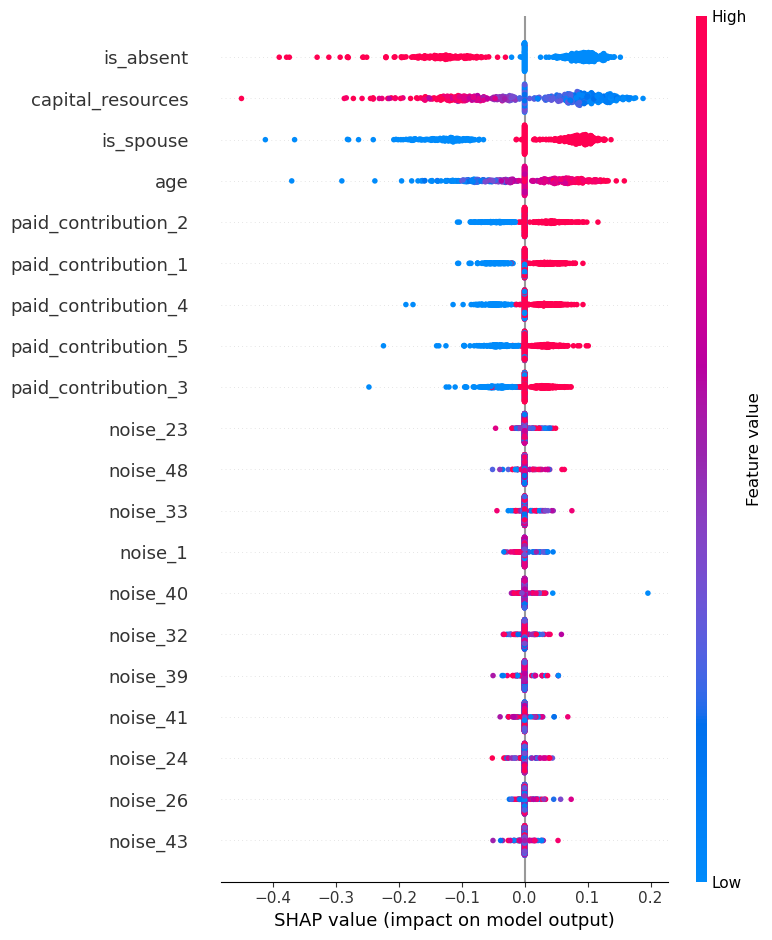

/var/folders/ks/35m02nj56fz74b975kbks3740000gn/T/ipykernel_32451/3290650389.py:123: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(_shap_to_2d(nn_shap_values),  X_sample_scaled, feature_names=feature_cols, show=True)


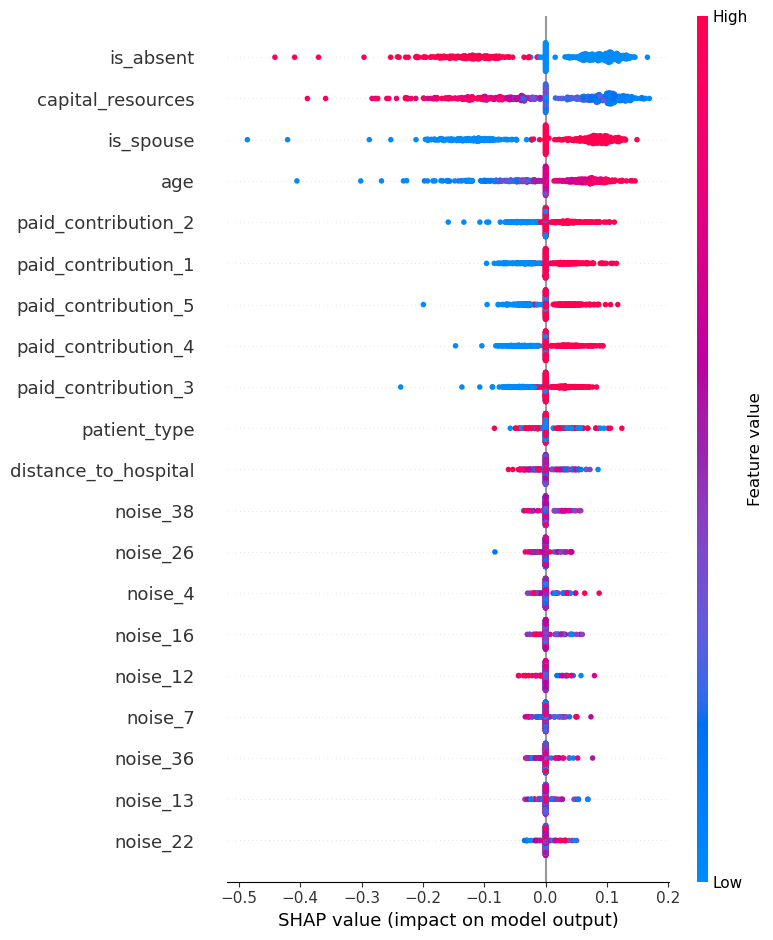

/var/folders/ks/35m02nj56fz74b975kbks3740000gn/T/ipykernel_32451/3290650389.py:124: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(_shap_to_2d(kan_shap_values), X_sample_scaled, feature_names=feature_cols, show=True)


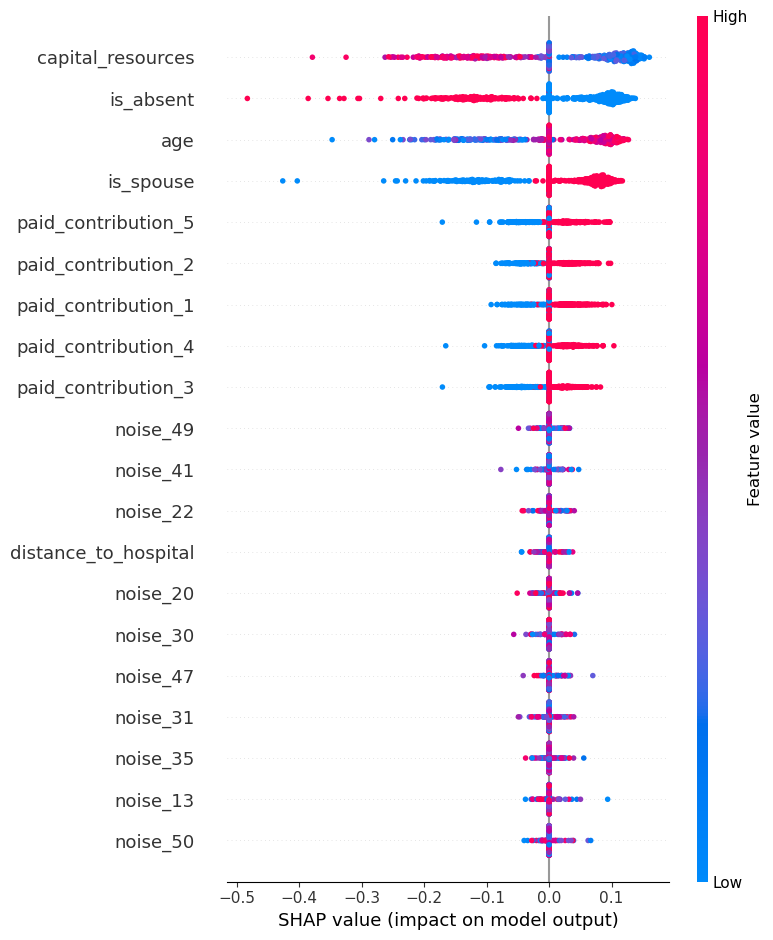

/var/folders/ks/35m02nj56fz74b975kbks3740000gn/T/ipykernel_32451/3290650389.py:125: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(_shap_to_2d(rf_shap_values),  X_sample_raw,    feature_names=feature_cols, show=True)


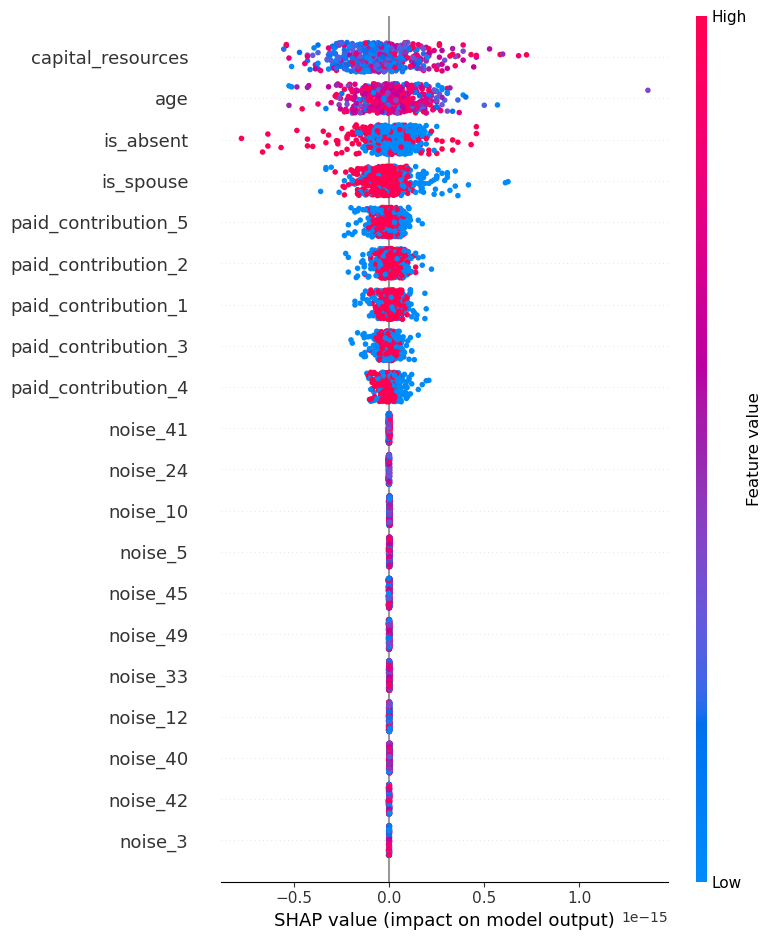


[LIME] Explainers...
[LIME] Local explanations...

Instance 0
  LR : [('is_absent', -0.1333816191839919), ('is_spouse', 0.13185210077257953), ('capital_resources', -0.12026018936733193), ('paid_contribution_1', 0.06795243397464779), ('paid_contribution_4', 0.06741291267049974), ('paid_contribution_5', 0.066917834260984), ('paid_contribution_3', 0.06477852612001087), ('paid_contribution_2', 0.061311567062964874)]
  NN : [('is_spouse', 0.11223455134294552), ('is_absent', -0.10333994761723825), ('capital_resources', -0.09037320765893157), ('paid_contribution_5', 0.05108029430715803), ('paid_contribution_3', 0.04833329791511179), ('paid_contribution_1', 0.04590237044638465), ('paid_contribution_4', 0.04176348230319993), ('paid_contribution_2', 0.04133310018319386)]
  KAN: [('capital_resources', -0.056151822365678054), ('is_absent', -0.055142498739070345), ('is_spouse', 0.0518721121467322), ('paid_contribution_4', 0.024913635960707274), ('paid_contribution_1', 0.023473033078555992), ('paid

/opt/anaconda3/envs/ml_finance/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


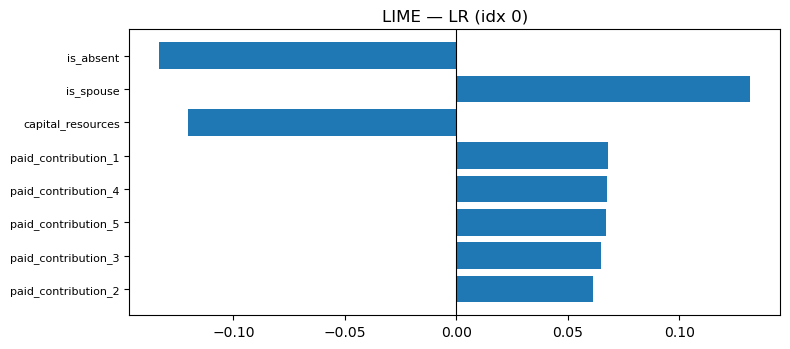

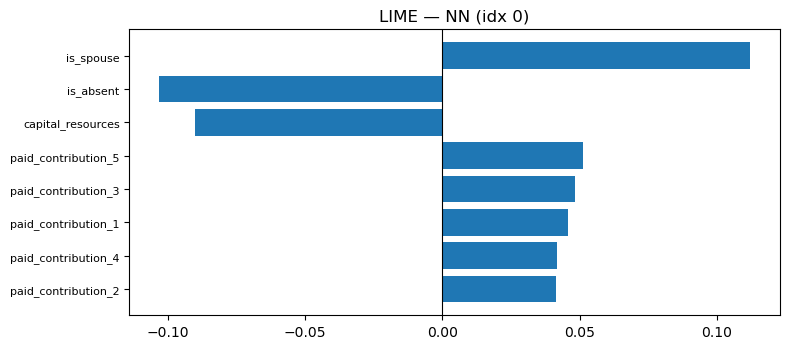

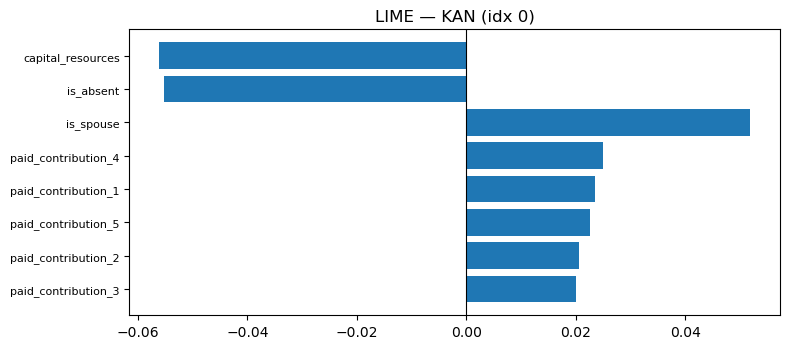

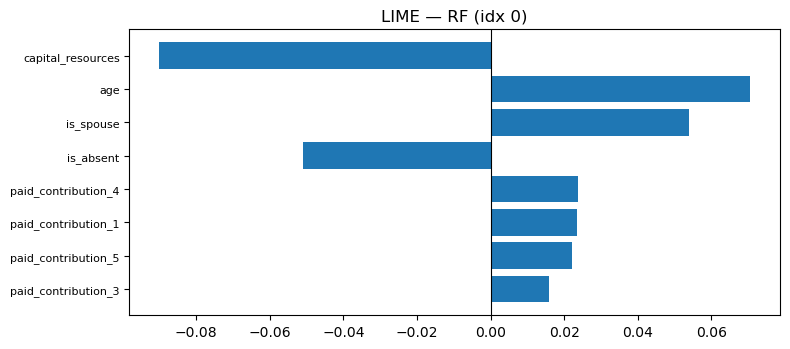


Instance 50
  LR : [('is_absent', -0.14036350912115536), ('is_spouse', 0.14026188866984526), ('capital_resources', -0.12875573803617926), ('paid_contribution_1', 0.06690515003407888), ('paid_contribution_4', 0.06511518166141955), ('paid_contribution_5', 0.06412736442537753), ('paid_contribution_3', 0.06375483076454563), ('paid_contribution_2', 0.06206176951761883)]
  NN : [('is_spouse', 0.11715647408198639), ('is_absent', -0.11347205879940817), ('capital_resources', -0.10109043622757136), ('paid_contribution_1', 0.05042622155247267), ('paid_contribution_4', 0.04967385572842792), ('paid_contribution_3', 0.04942007217781708), ('paid_contribution_2', 0.048795384517783064), ('paid_contribution_5', 0.04747008111545322)]
  KAN: [('is_absent', -0.061345589125170574), ('is_spouse', 0.057316971357480644), ('capital_resources', -0.05535383427393291), ('paid_contribution_3', 0.024321483904591525), ('paid_contribution_2', 0.022957233361917042), ('paid_contribution_4', 0.021844086551517084), ('pai

/opt/anaconda3/envs/ml_finance/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


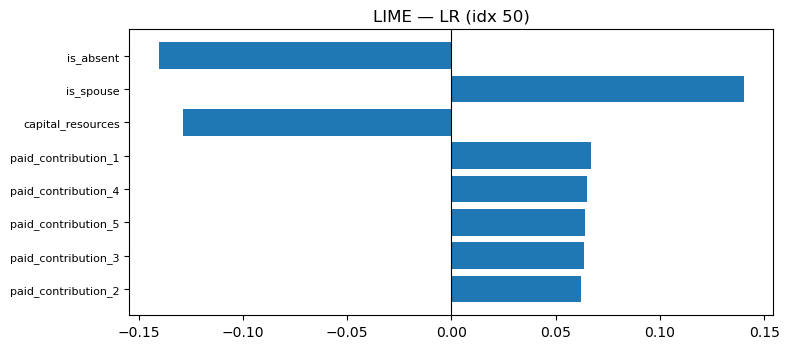

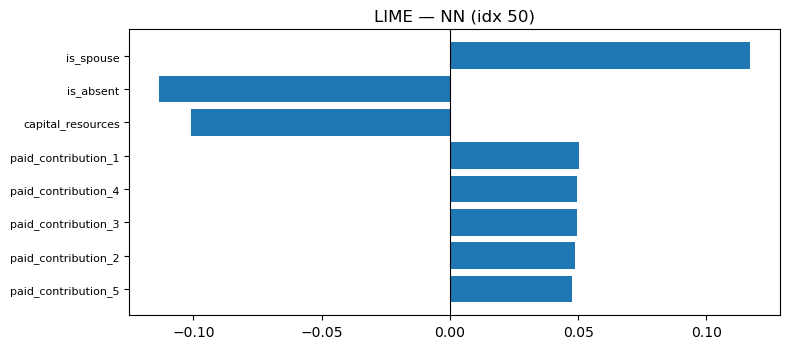

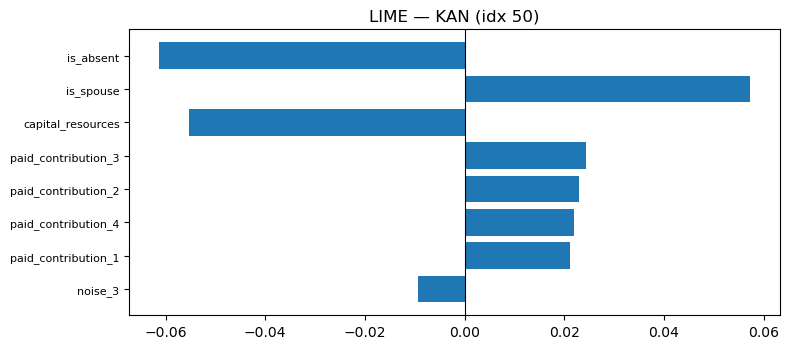

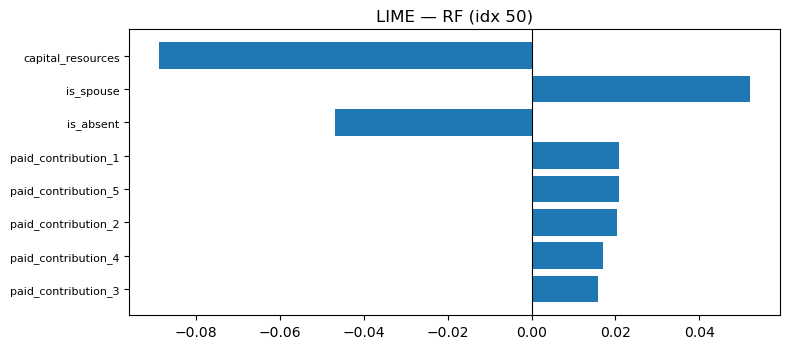


Instance 200
  LR : [('is_spouse', 0.14654624168082447), ('is_absent', -0.14567069203421867), ('capital_resources', -0.13193590470153996), ('paid_contribution_2', 0.07818134733415122), ('paid_contribution_1', 0.07174372466473126), ('paid_contribution_4', 0.07036243814038089), ('paid_contribution_5', 0.06873735522177407), ('paid_contribution_3', 0.06688112462951888)]
  NN : [('is_spouse', 0.1231538091380259), ('is_absent', -0.12141467412930892), ('capital_resources', -0.10947420353244927), ('paid_contribution_1', 0.05508771945614846), ('paid_contribution_4', 0.055035812319279995), ('paid_contribution_2', 0.054928550004736426), ('paid_contribution_5', 0.05338395127570053), ('paid_contribution_3', 0.05199093064226093)]
  KAN: [('is_absent', -0.061155180000504815), ('is_spouse', 0.05882805421349897), ('capital_resources', -0.05822311258411317), ('age', 0.04625902319492466), ('paid_contribution_5', 0.030394047432319382), ('paid_contribution_4', 0.029089666840984484), ('paid_contribution_2'

/opt/anaconda3/envs/ml_finance/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


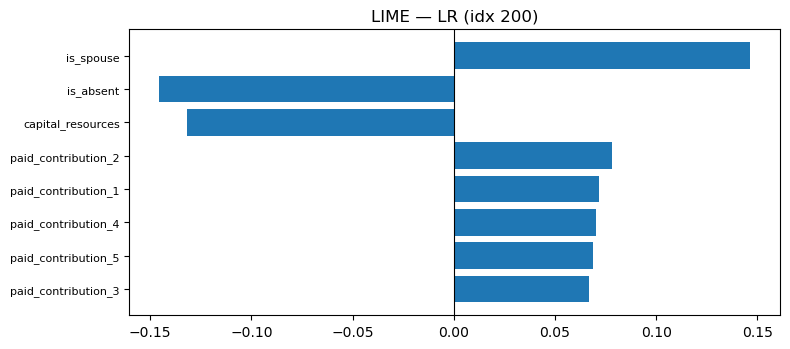

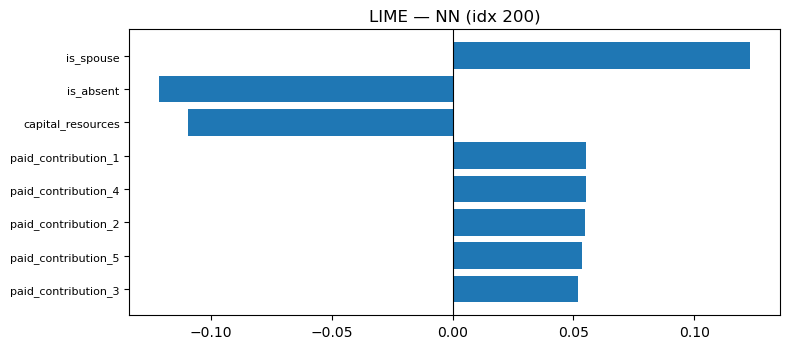

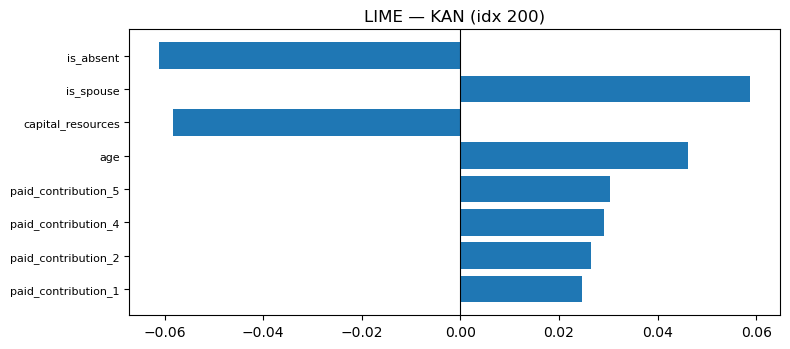

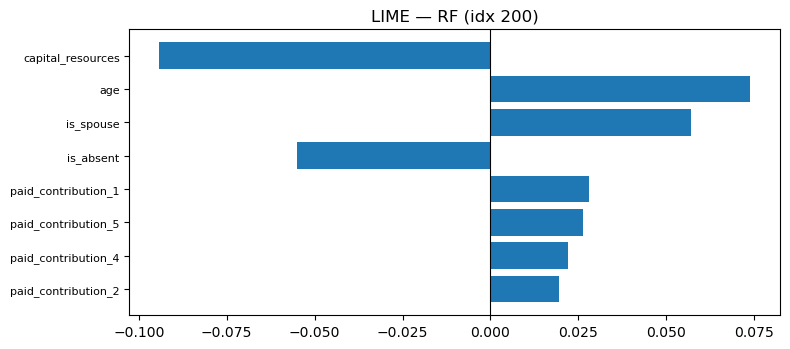


Section 12 complete.


In [75]:


# Helpers
def _shap_to_2d(shap_vals):
    """Return SHAP values as (n_samples, n_features)."""
    if isinstance(shap_vals, list):  # binary-class list -> take positive class
        shap_vals = shap_vals[-1]
    arr = np.array(shap_vals)
    if arr.ndim == 3:               # multi-output -> average over outputs
        arr = arr.mean(axis=2)
    return arr

def top_mean_abs_shap(shap_vals, feat_names, topk=10):
    arr = _shap_to_2d(shap_vals)
    mean_abs = np.abs(arr).mean(axis=0)
    order = np.argsort(-mean_abs)[:topk]
    return [(feat_names[int(i)], float(mean_abs[int(i)])) for i in order]

def sign_compliance(shap_vals, feat_names, pos_feat=None, neg_feat=None):
    """Fraction of cases with expected SHAP sign for specified features."""
    arr = _shap_to_2d(shap_vals)
    out = {}
    if pos_feat in feat_names:
        j = feat_names.index(pos_feat)
        out[f"{pos_feat}_positive_frac"] = float((arr[:, j] > 0).mean())
    if neg_feat in feat_names:
        j = feat_names.index(neg_feat)
        out[f"{neg_feat}_negative_frac"] = float((arr[:, j] < 0).mean())
    return out

def plot_lime_bar(explanation, title):
    contribs = explanation.as_list()
    feats = [f for f, _ in contribs]
    vals  = [v for _, v in contribs]
    y = np.arange(len(vals))[::-1]
    plt.figure(figsize=(8, max(3, 0.45*len(vals))))
    plt.barh(y, vals)
    plt.yticks(y, feats, fontsize=8)
    plt.axvline(0, color='k', linewidth=0.8)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Data frames for scaled and raw views
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=feature_cols)

# Recreate raw space for RF if scaler is available
try:
    X_train_raw = scaler.inverse_transform(X_train_scaled)
    X_test_raw  = scaler.inverse_transform(X_test_scaled)
    X_train_raw_df = pd.DataFrame(X_train_raw, columns=feature_cols)
    X_test_raw_df  = pd.DataFrame(X_test_raw,  columns=feature_cols)
except Exception:
    X_train_raw_df = X_train_scaled_df.copy()
    X_test_raw_df  = X_test_scaled_df.copy()

# Background samples (balanced, small)
bg_n = min(300, len(X_train_scaled_df))
background_scaled = shap.sample(X_train_scaled_df, bg_n, random_state=42)
background_raw    = shap.sample(X_train_raw_df,    bg_n, random_state=42)

# Evaluation samples
sample_n = min(500, len(X_test_scaled_df))
X_sample_scaled = X_test_scaled_df.iloc[:sample_n].copy()
X_sample_raw    = X_test_raw_df.iloc[:sample_n].copy()

# Predictors returning P(y=1)
def pred_lr_proba_scaled(X_np):  return lr.predict_proba(X_np)[:, 1]
def pred_nn_proba_scaled(X_np):  return nn.predict_proba(X_np)[:, 1]
def pred_rf_proba_raw(X_np):     return rf.predict_proba(X_np)[:, 1]
def pred_kan_proba_scaled(X_np):
    with torch.no_grad():
        x = torch.tensor(X_np, dtype=torch.float32)
        logits = kan_model(x).squeeze(1)
        return torch.sigmoid(logits).cpu().numpy()

# SHAP
print("\n[SHAP] Explainers...")
rf_tree_explainer = shap.TreeExplainer(rf)
rf_shap_values = _shap_to_2d(rf_tree_explainer.shap_values(X_sample_raw.values))

lr_kernel  = shap.KernelExplainer(pred_lr_proba_scaled,  background_scaled.values)
nn_kernel  = shap.KernelExplainer(pred_nn_proba_scaled,  background_scaled.values)
kan_kernel = shap.KernelExplainer(pred_kan_proba_scaled, background_scaled.values)

nsamp = 150
print("[SHAP] Computing values...")
lr_shap_values  = lr_kernel.shap_values(X_sample_scaled.values,  nsamples=nsamp)
nn_shap_values  = nn_kernel.shap_values(X_sample_scaled.values,  nsamples=nsamp)
kan_shap_values = kan_kernel.shap_values(X_sample_scaled.values, nsamples=nsamp)

# Global summaries
print("\n[SHAP] Top mean |SHAP| features (global):")
for name, shap_vals, feats in [
    ("LR (scaled)",  lr_shap_values,  feature_cols),
    ("RF (raw)",     rf_shap_values,  feature_cols),
    ("NN (scaled)",  nn_shap_values,  feature_cols),
    ("KAN (scaled)", kan_shap_values, feature_cols),
]:
    top10 = top_mean_abs_shap(shap_vals, feats, topk=10)
    print(f"  {name}:")
    for f, v in top10:
        print(f"    - {f:25s} {v:.4f}")

# Rule sign checks
print("\n[SHAP] Rule sign compliance (Age +, Capital −):")
for name, sv, feats in [
    ("LR",  lr_shap_values,  feature_cols),
    ("RF",  rf_shap_values,  feature_cols),
    ("NN",  nn_shap_values,  feature_cols),
    ("KAN", kan_shap_values, feature_cols),
]:
    chk = sign_compliance(sv, feats, pos_feat="age", neg_feat="capital_resources")
    print(f"  {name}: {chk}")

# SHAP visuals
print("\n[SHAP] Summary plots...")
plt.figure(figsize=(1,1)); plt.close()
shap.summary_plot(_shap_to_2d(lr_shap_values),  X_sample_scaled, feature_names=feature_cols, show=True)
shap.summary_plot(_shap_to_2d(nn_shap_values),  X_sample_scaled, feature_names=feature_cols, show=True)
shap.summary_plot(_shap_to_2d(kan_shap_values), X_sample_scaled, feature_names=feature_cols, show=True)
shap.summary_plot(_shap_to_2d(rf_shap_values),  X_sample_raw,    feature_names=feature_cols, show=True)

# LIME
print("\n[LIME] Explainers...")
lime_scaled = LimeTabularExplainer(
    training_data=X_train_scaled_df.values,
    feature_names=feature_cols,
    class_names=['ineligible', 'eligible'],
    mode='classification',
    discretize_continuous=False,
    random_state=42
)
lime_raw = LimeTabularExplainer(
    training_data=X_train_raw_df.values,
    feature_names=feature_cols,
    class_names=['ineligible', 'eligible'],
    mode='classification',
    discretize_continuous=False,
    random_state=42
)

def lime_pred_lr(X):
    p = pred_lr_proba_scaled(X);  return np.vstack([1 - p, p]).T
def lime_pred_nn(X):
    p = pred_nn_proba_scaled(X);  return np.vstack([1 - p, p]).T
def lime_pred_kan(X):
    p = pred_kan_proba_scaled(X); return np.vstack([1 - p, p]).T
def lime_pred_rf(X):
    p = pred_rf_proba_raw(X);     return np.vstack([1 - p, p]).T

# Instances to explain 
lime_idxs = [0, min(50, len(X_test_scaled_df)-1), min(200, len(X_test_scaled_df)-1)]

print("[LIME] Local explanations...")
for idx in lime_idxs:
    x_scaled = X_test_scaled_df.iloc[idx].values
    x_raw    = X_test_raw_df.iloc[idx].values

    exp_lr  = lime_scaled.explain_instance(x_scaled, lime_pred_lr,  num_features=8)
    exp_nn  = lime_scaled.explain_instance(x_scaled, lime_pred_nn,  num_features=8)
    exp_kan = lime_scaled.explain_instance(x_scaled, lime_pred_kan, num_features=8)
    exp_rf  = lime_raw.explain_instance(   x_raw,    lime_pred_rf,  num_features=8)

    print(f"\nInstance {idx}")
    print("  LR :", exp_lr.as_list())
    print("  NN :", exp_nn.as_list())
    print("  KAN:", exp_kan.as_list())
    print("  RF :", exp_rf.as_list())

    plot_lime_bar(exp_lr,  f"LIME — LR (idx {idx})")
    plot_lime_bar(exp_nn,  f"LIME — NN (idx {idx})")
    plot_lime_bar(exp_kan, f"LIME — KAN (idx {idx})")
    plot_lime_bar(exp_rf,  f"LIME — RF (idx {idx})")

print("\nSection 12 complete.")